<a href="https://colab.research.google.com/github/Davs07/Modelo---Fatiga-Facial/blob/main/Modelo_Fatiga_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# import kagglehub
# ismailnasri20_driver_drowsiness_dataset_ddd_path = kagglehub.dataset_download('ismailnasri20/driver-drowsiness-dataset-ddd')

# print('Data source import complete.')


In [ ]:
# Subir credenciales de Kaggle
from google.colab import files
files.upload()  # Subir el archivo kaggle.json

# Configurar kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar dataset
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd
!unzip driver-drowsiness-dataset-ddd.zip -d /content/driver_drowsiness_dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: /content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating:

In [ ]:
import os

data_dir = "/content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)"
print("Archivos y carpetas extraídos:")
print(os.listdir(data_dir))


Archivos y carpetas extraídos:
['Non Drowsy', 'Drowsy']


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import shutil

# Define paths
data_dir = "/content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)"  # Update this to your dataset path
drowsy_dir = os.path.join(data_dir, 'Drowsy')
non_drowsy_dir = os.path.join(data_dir, 'Non Drowsy')

# Ensure dataset directories exist
assert os.path.exists(drowsy_dir), "Drowsy folder not found"
assert os.path.exists(non_drowsy_dir), "Non-drowsy folder not found"

# Create train, val, test directories
output_dir = "prepared_data"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

for split in [train_dir, val_dir, test_dir]:
    for category in ["drowsy", "non_drowsy"]:
        os.makedirs(os.path.join(split, category), exist_ok=True)

# Helper function to split and copy files
def split_and_copy(source_dir, target_dirs, split_ratios):
    filenames = os.listdir(source_dir)
    train, test = train_test_split(filenames, test_size=split_ratios[1] + split_ratios[2], random_state=42)
    val, test = train_test_split(test, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)

    splits = {"train": train, "val": val, "test": test}
    for split_name, files in splits.items():
        split_path = target_dirs[split_name]
        category_name = os.path.basename(source_dir)  # 'Drowsy' or 'Non Drowsy'
        category_path = os.path.join(split_path, category_name.lower().replace(" ", "_"))  # Convert to lowercase and underscores

        # Create subdirectory if it doesn't exist
        os.makedirs(category_path, exist_ok=True)

        for file in files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(category_path, file))

# Split the data
split_and_copy(drowsy_dir, {"train": train_dir, "val": val_dir, "test": test_dir}, [0.7, 0.2, 0.1])
split_and_copy(non_drowsy_dir, {"train": train_dir, "val": val_dir, "test": test_dir}, [0.7, 0.2, 0.1])

# ImageDataGenerator for data loading and augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=20, zoom_range=0.15, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_generator, validation_data=val_generator, epochs=10, steps_per_epoch=train_generator.samples//train_generator.batch_size, validation_steps=val_generator.samples//val_generator.batch_size)

# Save model
model.save("drowsiness_detection_model.h5")

# Evaluate on test set
test_generator = val_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Found 29254 images belonging to 2 classes.
Found 8359 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


914/914 ━━━━━━━━━━━━━━━━━━━━ 439s 463ms/step - accuracy: 0.6001 - loss: 0.7246 - val_accuracy: 0.8497 - val_loss: 0.4497
Epoch 2/10
  1/914 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.6875 - loss: 0.5249

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


914/914 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6875 - loss: 0.5249 - val_accuracy: 0.5714 - val_loss: 0.6854
Epoch 3/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 473s 452ms/step - accuracy: 0.7538 - loss: 0.4958 - val_accuracy: 0.9168 - val_loss: 0.3262
Epoch 4/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 0s 39us/step - accuracy: 0.7812 - loss: 0.4565 - val_accuracy: 0.8571 - val_loss: 0.3313
Epoch 5/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 442s 452ms/step - accuracy: 0.8097 - loss: 0.4143 - val_accuracy: 0.9454 - val_loss: 0.2634
Epoch 6/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8438 - loss: 0.3176 - val_accuracy: 0.8571 - val_loss: 0.4081
Epoch 7/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 416s 452ms/step - accuracy: 0.8371 - loss: 0.3667 - val_accuracy: 0.9597 - val_loss: 0.2160
Epoch 8/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.8125 - loss: 0.3531 - val_accuracy: 1.0000 - val_loss: 0.1037
Epoch 9/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 415s 451ms/step - accuracy: 0.8535 - loss: 0.3313 - val_a

Found 4180 images belonging to 2 classes.
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9747 - loss: 0.1737
Test Accuracy: 97.34%


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Load the trained model
model_path = "/content/drowsiness_detection_model.h5"  # Replace with the path to your saved model
model = tf.keras.models.load_model(model_path)

# Define a function to make predictions
def predict_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Match input size of the model
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Make a prediction
    prediction = model.predict(img_array)[0][0]

    # Map the prediction to the correct label
    if prediction >= 0.5:
        label = "Non-Drowsy"  # Prediction corresponds to class label 1
    else:
        label = "Drowsy"  # Prediction corresponds to class label 0

    # Display the image with the predicted label
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label}")
    plt.show()

    return label


# Test the function with an image from the test dataset
for i in range(20,31):

    test_image_path = f"/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A00{random.randint(10,99)}.png" if random.randint(0,100)%2==0 else f"/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/a00{random.randint(10,99)}.png"  # Replace with a test image path
    if os.path.exists(test_image_path):
        result = predict_image(test_image_path)
        print(f"Prediction: {result}")
    else:
        print(f"Test image not found: {test_image_path}")

Test image not found: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A0044.png
Test image not found: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/a0066.png
Test image not found: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/a0049.png
Test image not found: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/a0032.png
Test image not found: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A0026.png
Test image not found: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A0086.png
Test image not found: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/a0049.png
Test image not found: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/a0047.png
Test image not found: /kaggle/input/driver-drowsiness-datase

In [ ]:
import tensorflow as tf

# Load the .h5 model
model = tf.keras.models.load_model('/content/drowsiness_detection_model.h5')


In [ ]:
model.save('/content/my_model.h5')

In [ ]:
import tensorflow as tf

# Load the .h5 model
model = tf.keras.models.load_model('/content/my_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite model
with open('/content/my_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TFLite and saved!")


Saved artifact at '/tmp/tmp8a1bmpld'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138723317738832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317740176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317740368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317739984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317739408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317740752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317742096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317742288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317741904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317741136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138723317742672

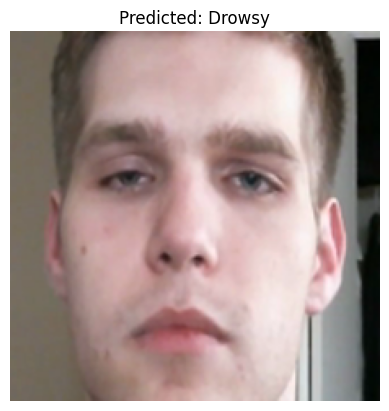

Prediction: Drowsy


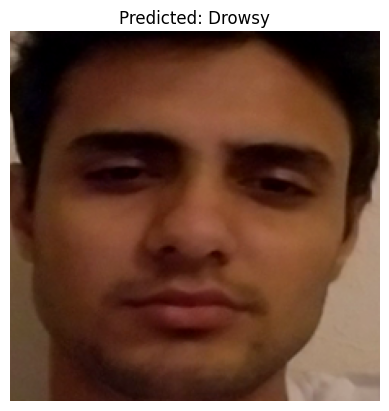

Prediction: Drowsy


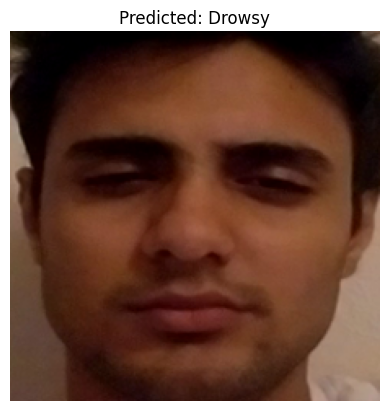

Prediction: Drowsy


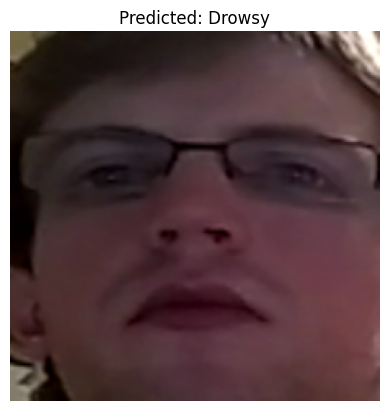

Prediction: Drowsy


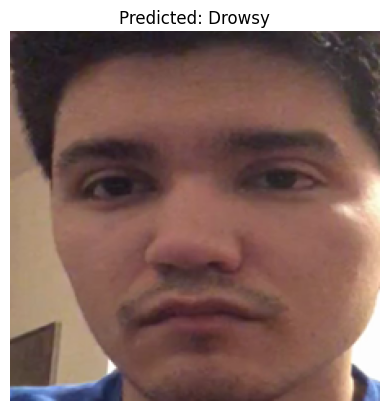

Prediction: Drowsy


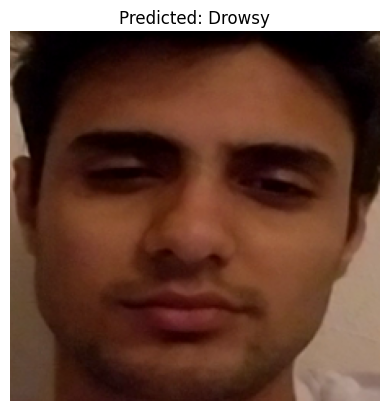

Prediction: Drowsy


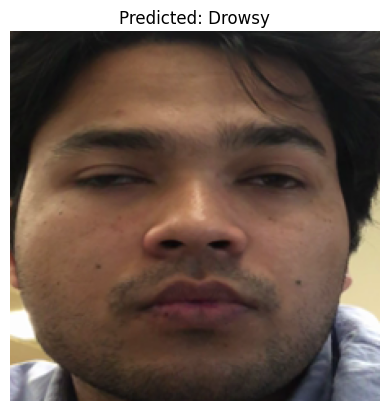

Prediction: Drowsy


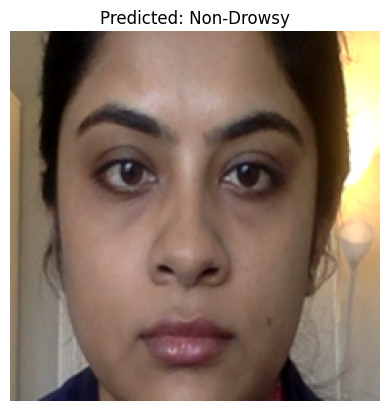

Prediction: Non-Drowsy


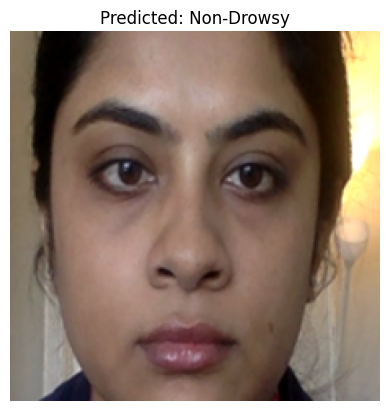

Prediction: Non-Drowsy


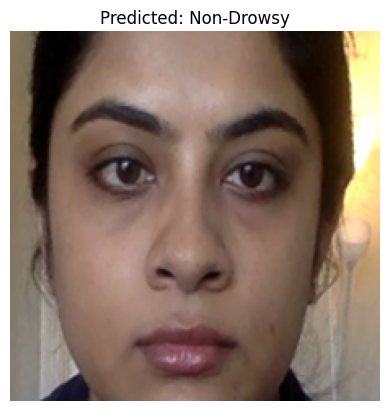

Prediction: Non-Drowsy


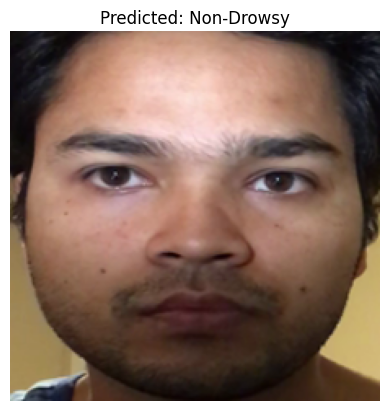

Prediction: Non-Drowsy


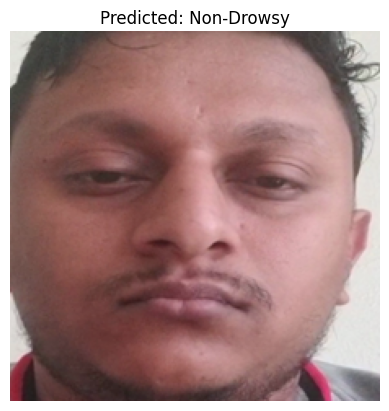

Prediction: Non-Drowsy


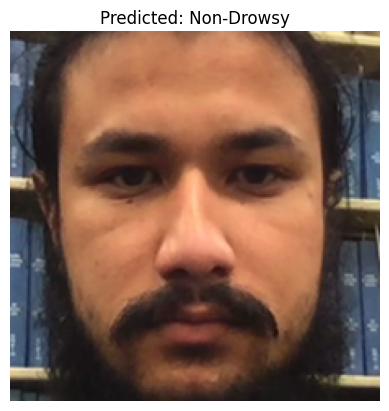

Prediction: Non-Drowsy


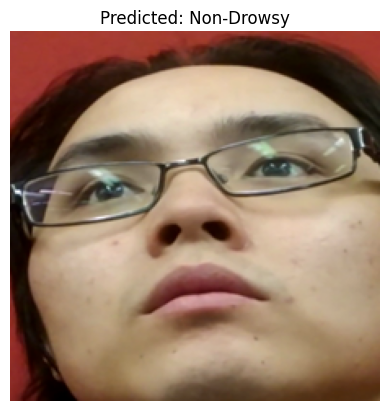

Prediction: Non-Drowsy


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load the TFLite model
tflite_model_path = "/content/my_model.tflite"  # Replace with the path to your saved TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define a function to preprocess image for TFLite inference
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to the input shape of the model
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img.astype(np.float32)

# Define a function to make predictions using TFLite model
def predict_image(image_path):
    # Preprocess the image
    input_image = preprocess_image(image_path)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Run inference
    interpreter.invoke()

    # Get the prediction
    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = output_data[0][0]  # The model's output for binary classification

    # Map the prediction to the correct label
    if prediction >= 0.5:
        label = "Non-Drowsy"  # Prediction corresponds to class label 1
    else:
        label = "Drowsy"  # Prediction corresponds to class label 0

    # Load the image again to display
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Display the image with the predicted label
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label}")
    plt.show()

    return label

# Function to sample random images from Drowsy and Non-Drowsy folders
def sample_images(dataset_path, sample_size=15):
    """Samples random images from Drowsy and Non-Drowsy folders."""
    categories = ['Drowsy', 'Non Drowsy']
    images = []

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        category_images = os.listdir(category_path)
        sampled_images = random.sample(category_images, sample_size // 2)
        images.extend([os.path.join(category_path, img) for img in sampled_images])

    return images

dataset_path = "/content/driver_drowsiness_dataset/Driver Drowsiness Dataset (DDD)"
sampled_images = sample_images(dataset_path, sample_size=15)

# Perform inference on sampled images and display results
for img_path in sampled_images:
    if os.path.exists(img_path):
        result = predict_image(img_path)
        print(f"Prediction: {result}")
    else:
        print(f"Test image not found: {img_path}")
